<a href="https://colab.research.google.com/github/kirubanath/computer-vision/blob/main/Kirubanath_LA6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 6

**Computer Vision** - Term 5, 2023

Instructor: Dr. Saumya Jetley <br>
TAs: Ribhu Lahiri, Raghav Awasty

Total points: 5 (with potential extra credit)

In this lab, you will be working with autoencoders, and visualising the what the layers in a CNN "see".

In [8]:
import cv2
import math
import torch
import warnings
import numpy as np
import torchvision
import pandas as pd
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torchvision import datasets, transforms

In [9]:
warnings.filterwarnings("ignore", module = "matplotlib\..*" )
torch.manual_seed(42)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(device)

cpu


## Part 1 – The Autoencoder (2 points)

In the first part, you will be creating a simple autoencoder with one hidden layer in each of the encoder and decoder. There are dimensions already specified but feel free to experiment.

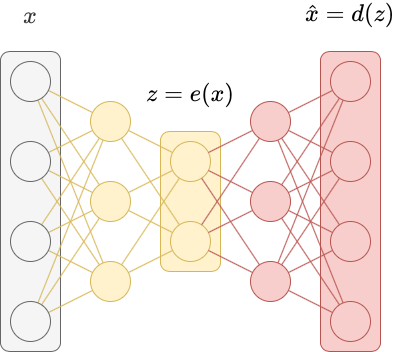

**Implement the `Encoder`** *(0.5 point)*

In [23]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=28*28 , out_features= 512)
        self.linear2 = torch.nn.Linear(in_features=512   , out_features= latent_dims)


    def forward(self, x):
      x = self.flatten(x)
      x = self.linear1(x)
      x = torch.nn.functional.relu(x)
      x = self.linear2(x)
      return x 

**Implement the `Decoder`** *(0.5 point)*

In [24]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=latent_dims , out_features= 512)
        self.linear2 = torch.nn.Linear(in_features=512         , out_features= 28*28)

    def forward(self, z):
        x = self.linear1(z)
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)
        x = torch.nn.functional.sigmoid(x)
        x = x.view(-1,1,28,28)
        return x

In [25]:
class Autoencoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

**Create the training loop using the `train` function** *(1 point)*

HINT: You can re-use parts from the lab on MLP, such as the loss function but the weight updates will need to be done through an optimizer (`torch.optim`)

In [31]:
def train(autoencoder, data, dev = device, epochs=20):

    #loss function:
    criterian = torch.nn.MSELoss()

    #optimizer:
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

    #training loop:
    for epoch in range(epochs):
      running_loss = 0

      for batch in data:
        #step0: get only the image data and move the tensor to cuda:
        batch = batch[0]

        #step1: zero the gradients:
        optimizer.zero_grad()

        #step2: forward pass:
        outputs = autoencoder(batch)

        #step3: compute loss:
        loss = criterian(outputs,batch)

        #step4: backward pass:
        loss.backward()

        #step5: update weights:
        optimizer.step()

        #step6: update running loss:
        running_loss +=loss.item()
      
      # print average loss:
      avg_loss = running_loss/len(data)
      print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")



In [32]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)

data = torch.utils.data.DataLoader(
        MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=256,
        shuffle=True)

train(autoencoder, data)

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/20, Loss: 0.0611
Epoch 2/20, Loss: 0.0500
Epoch 3/20, Loss: 0.0477
Epoch 4/20, Loss: 0.0467
Epoch 5/20, Loss: 0.0459
Epoch 6/20, Loss: 0.0452
Epoch 7/20, Loss: 0.0447
Epoch 8/20, Loss: 0.0443
Epoch 9/20, Loss: 0.0440
Epoch 10/20, Loss: 0.0436
Epoch 11/20, Loss: 0.0433
Epoch 12/20, Loss: 0.0431
Epoch 13/20, Loss: 0.0428
Epoch 14/20, Loss: 0.0426
Epoch 15/20, Loss: 0.0424
Epoch 16/20, Loss: 0.0422
Epoch 17/20, Loss: 0.0420
Epoch 18/20, Loss: 0.0419
Epoch 19/20, Loss: 0.0417
Epoch 20/20, Loss: 0.0416


In [33]:
batch = next(iter(data))
#vizualization:
inputs = []
for i in range(9):
  inputs.append(batch[0][i])

outputs = autoencoder(batch[0])
outputs = outputs[:10]
outputs = outputs.detach().numpy()

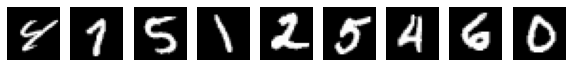

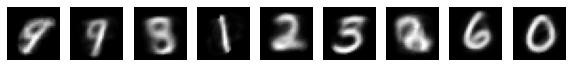

In [34]:
fig = plt.figure(figsize=(10,8))
for i in range(9):
  plt.subplot(1,9,i+1)
  plt.imshow(inputs[i][0,:,:],cmap = "gray")
  plt.axis("off")

fig = plt.figure(figsize=(10,8))
for i in range(9):
  plt.subplot(1,9,i+1)
  plt.imshow(outputs[i][0,:,:],cmap = "gray")
  plt.axis("off")

## Part 2 – The Variational Autoencoder (1 point)

In the second part, you will extend your encoder to be Variational so that it becomes a Variational Autoencoder. The distribution you need to map it to is a Normal distribution and use KL divergence as an Auxilliary Loss.

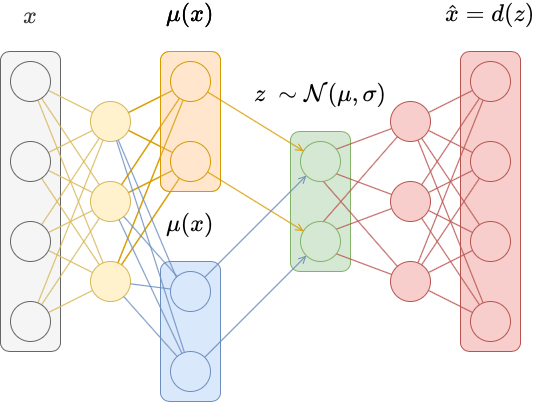

**Implement the `VariationalEncoder`** *(1 point)*

In [16]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        # encoder layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        # decoder layers
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [17]:
# set up the data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# set up the VAE model
model = VAE(input_size=784, hidden_size=256, latent_size=20).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    # iterate over the training data loader
    for batch_idx, (data, _) in enumerate(train_loader):
        # move data to GPU
        data = data.to('cuda')
        # zero out the optimizer gradients
        optimizer.zero_grad()
        # pass the input through the VAE model
        recon_batch, mu, logvar = model(data)
        # calculate the loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # backpropagate the loss
        loss.backward()
        # update the optimizer parameters
        train_loss += loss.item()
        optimizer.step()
        # print the training progress every 100 batches
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    # print the total training loss for the epoch
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


# train the VAE for 20 epochs
for epoch in range(1, 21):
    train(epoch)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 546.959778
Train Epoch: 1 [12800/60000 (21%)]	Loss: 196.805435
Train Epoch: 1 [25600/60000 (43%)]	Loss: 162.150909
Train Epoch: 1 [38400/60000 (64%)]	Loss: 148.815826
Train Epoch: 1 [51200/60000 (85%)]	Loss: 137.766525
====> Epoch: 1 Average loss: 174.2450
Train Epoch: 2 [0/60000 (0%)]	Loss: 129.660019
Train Epoch: 2 [12800/60000 (21%)]	Loss: 125.220856
Train Epoch: 2 [25600/60000 (43%)]	Loss: 126.919357
Train Epoch: 2 [38400/60000 (64%)]	Loss: 122.288635
Train Epoch: 2 [51200/60000 (85%)]	Loss: 119.917404
====> Epoch: 2 Average loss: 126.6791
Train Epoch: 3 [0/60000 (0%)]	Loss: 120.411316
Train Epoch: 3 [12800/60000 (21%)]	Loss: 122.289391
Train Epoch: 3 [25600/60000 (43%)]	Loss: 115.995895
Train Epoch: 3 [38400/60000 (64%)]	Loss: 118.077469
Train Epoch: 3 [51200/60000 (85%)]	Loss: 118.235641
====> Epoch: 3 Average loss: 118.1991
Train Epoch: 4 [0/60000 (0%)]	Loss: 116.7889

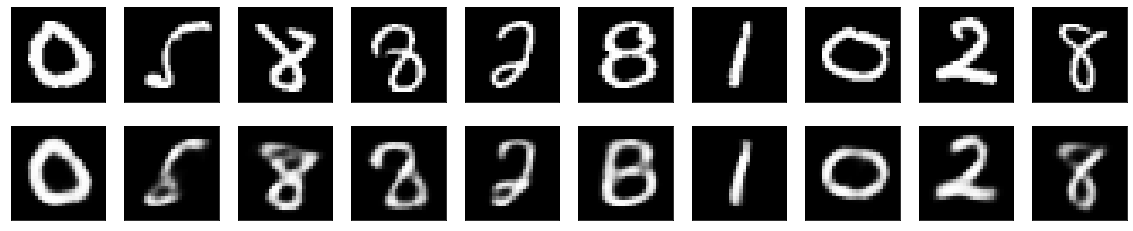

In [35]:
#vizualizing:

# set the model to evaluation mode
model.eval()

# get a batch of test data
test_data, _ = next(iter(test_loader))
test_data = test_data.to('cuda')

# pass the test data through the VAE model
with torch.no_grad():
    recon_data, _, _ = model(test_data)

# convert the data to CPU and reshape for plotting
test_data = test_data.cpu().numpy().reshape(-1, 28, 28)
recon_data = recon_data.cpu().numpy().reshape(-1, 28, 28)

# plot the original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))
for images, row in zip([test_data, recon_data], axes):
    for img, ax in zip(images, row):
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


## Part 3 – Convolutional VAE (1 point)
In the final part, you need to implelment a convolutional VAE wherein the initial layers of your encoder are replaced by convolutional layers. Remember to use even-shaped kernels.

**Implement the `ConvVariationalEncoder`** *(1 point)*

In [36]:
class ConvVariationalEncoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(ConvVariationalEncoder, self).__init__()

        # define the convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        # calculate the output size of the convolutional layers
        self.conv_out_layer_dim = 128 * 7 * 7

        # define the fully connected layers
        self.fc1 = nn.Linear(self.conv_out_layer_dim, 512)
        self.fc2 = nn.Linear(512, latent_dims)
        self.fc3 = nn.Linear(512, latent_dims)

    def forward(self, x):
        # pass the input through the convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten the output of the convolutional layers
        x = x.view(-1, self.conv_out_layer_dim)
        # pass the flattened output through the fully connected layers
        mu = self.fc2(F.relu(self.fc1(x)))
        logvar = self.fc3(F.relu(self.fc1(x)))
        # return the latent mu and logvar
        return mu, logvar


In [37]:
class ConvVariationalDecoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(ConvVariationalDecoder, self).__init__()

        # define the fully connected layers
        self.fc1 = nn.Linear(latent_dims, 512)
        self.fc2 = nn.Linear(512, 128 * 7 * 7)

        # define the transpose convolutional layers
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        # pass the latent variable through the fully connected layers
        x = F.relu(self.fc2(F.relu(self.fc1(z))))
        # reshape the output of the fully connected layers
        x = x.view(-1, 128, 7, 7)
        # pass the output through the transpose convolutional layers
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        # return the reconstructed image
        return x

class ConvVariationalAutoencoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(ConvVariationalAutoencoder, self).__init__()

        self.encoder = ConvVariationalEncoder(latent_dims)
        self.decoder = ConvVariationalDecoder(latent_dims)

    def forward(self, x):
        # pass the input through the encoder
        mu, logvar = self.encoder(x)
        # sample the latent variable
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # pass the latent variable through the decoder
        x_hat = self.decoder(z)
        # return the reconstructed image, mu, and logvar
        return x_hat, mu, logvar

def loss_function(x_hat, x, mu, logvar):
    # calculate the binary cross entropy loss
    BCE = F.binary_cross_entropy(x_hat, x, reduction='sum')
    # calculate the KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return the sum of the two losses
    return BCE + KLD


In [38]:
def train_conv_vae(model, train_loader, optimizer, device, epoch):
    # set the model to train mode
    model.train()
    train_loss = 0
    # iterate over the training data
    for batch_idx, (data, _) in enumerate(train_loader):
        # send the data to the device
        data = data.to(device)
        optimizer.zero_grad()
        # forward pass through the model
        recon_batch, mu, logvar = model(data)
        # calculate the loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # backpropagate the loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # print progress every 100 batches
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    # calculate the average loss for the epoch
    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss))
    return train_loss


In [39]:
latent_dims = 20
conv_vae = ConvVariationalAutoencoder(latent_dims).to(device)
optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)

n_epochs = 20
conv_vae_losses = []

for epoch in range(1, n_epochs + 1):
    train_loss = train_conv_vae(conv_vae, train_loader, optimizer, device, epoch)
    conv_vae_losses.append(train_loss)


Train Epoch: 1 [0/60000 (0%)]	Loss: 552.396057
Train Epoch: 1 [12800/60000 (21%)]	Loss: 201.576675
Train Epoch: 1 [25600/60000 (43%)]	Loss: 195.609161
Train Epoch: 1 [38400/60000 (64%)]	Loss: 162.893326
Train Epoch: 1 [51200/60000 (85%)]	Loss: 147.498398
====> Epoch: 1 Average loss: 181.4720
Train Epoch: 2 [0/60000 (0%)]	Loss: 137.331696
Train Epoch: 2 [12800/60000 (21%)]	Loss: 124.419785
Train Epoch: 2 [25600/60000 (43%)]	Loss: 119.283646
Train Epoch: 2 [38400/60000 (64%)]	Loss: 118.221336
Train Epoch: 2 [51200/60000 (85%)]	Loss: 113.860916
====> Epoch: 2 Average loss: 122.2683
Train Epoch: 3 [0/60000 (0%)]	Loss: 117.238785
Train Epoch: 3 [12800/60000 (21%)]	Loss: 108.315338
Train Epoch: 3 [25600/60000 (43%)]	Loss: 107.974686
Train Epoch: 3 [38400/60000 (64%)]	Loss: 105.729080
Train Epoch: 3 [51200/60000 (85%)]	Loss: 107.665703
====> Epoch: 3 Average loss: 110.5762
Train Epoch: 4 [0/60000 (0%)]	Loss: 105.502640
Train Epoch: 4 [12800/60000 (21%)]	Loss: 108.023209
Train Epoch: 4 [25600/

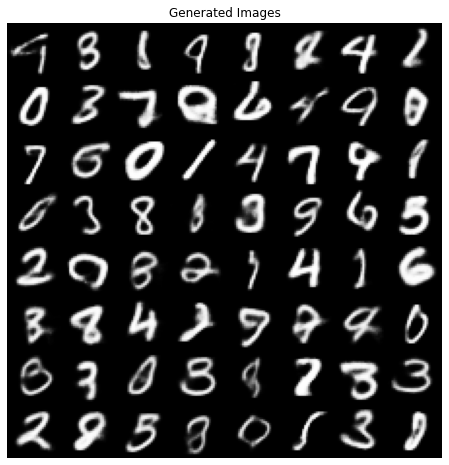

In [40]:
#visualizing the output:

# generate 64 random latent variables
z = torch.randn(64, latent_dims).to(device)

# generate reconstructed images using the decoder
with torch.no_grad():
    sample = conv_vae.decoder(z).cpu()

# reshape the sample tensor to a 8x8 grid of images
sample_grid = np.transpose(sample.view(8, 8, 1, 28, 28), (0, 3, 1, 4, 2))
sample_grid = np.reshape(sample_grid, (8 * 28, 8 * 28))

# plot the sample grid using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(sample_grid, cmap='gray')
plt.title("Generated Images")
plt.axis('off')
plt.show()

In the following parts, try to visualise your kernels. Use the code as reference, and modify it as you like. What can you say about the filters? Would using deconvolutions change how they look?

### Layer 1 Visualisation

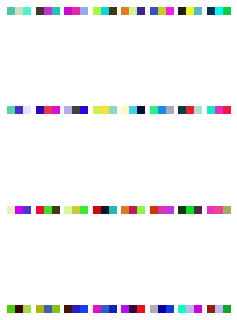

In [49]:
fig = plt.figure(figsize=(4,7))
detached = conv_vae.state_dict()['encoder.conv1.weight'].cpu().detach().numpy()
for i,filt in enumerate(detached):
    ax1 = fig.add_subplot(4,8,i+1)
    ax1.imshow((filt * 255).astype(np.uint8),cmap='gray')
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

### Layer 2 Visualisation

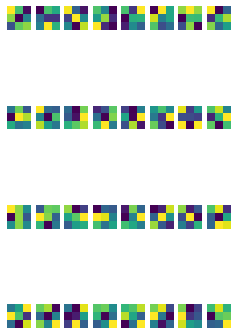

In [47]:
fig = plt.figure(figsize=(4,7))
detached = conv_vae.state_dict()['encoder.conv2.weight'][0].cpu().detach().numpy()
for i,filt in enumerate(detached):
    ax1 = fig.add_subplot(4,8,i+1)
    ax1.imshow(filt)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

## Part 4 – Visualising Layers using Deconvolutions and Unpooling (1 point)

In the final part of the lab, you will be using methods mentioned in [Zeiler and Fergus' work](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf). We use a pretrained AlexNet model, and attach these deconvolution and unpooling layers at points to reconstruct the feature attributions in pixel space.

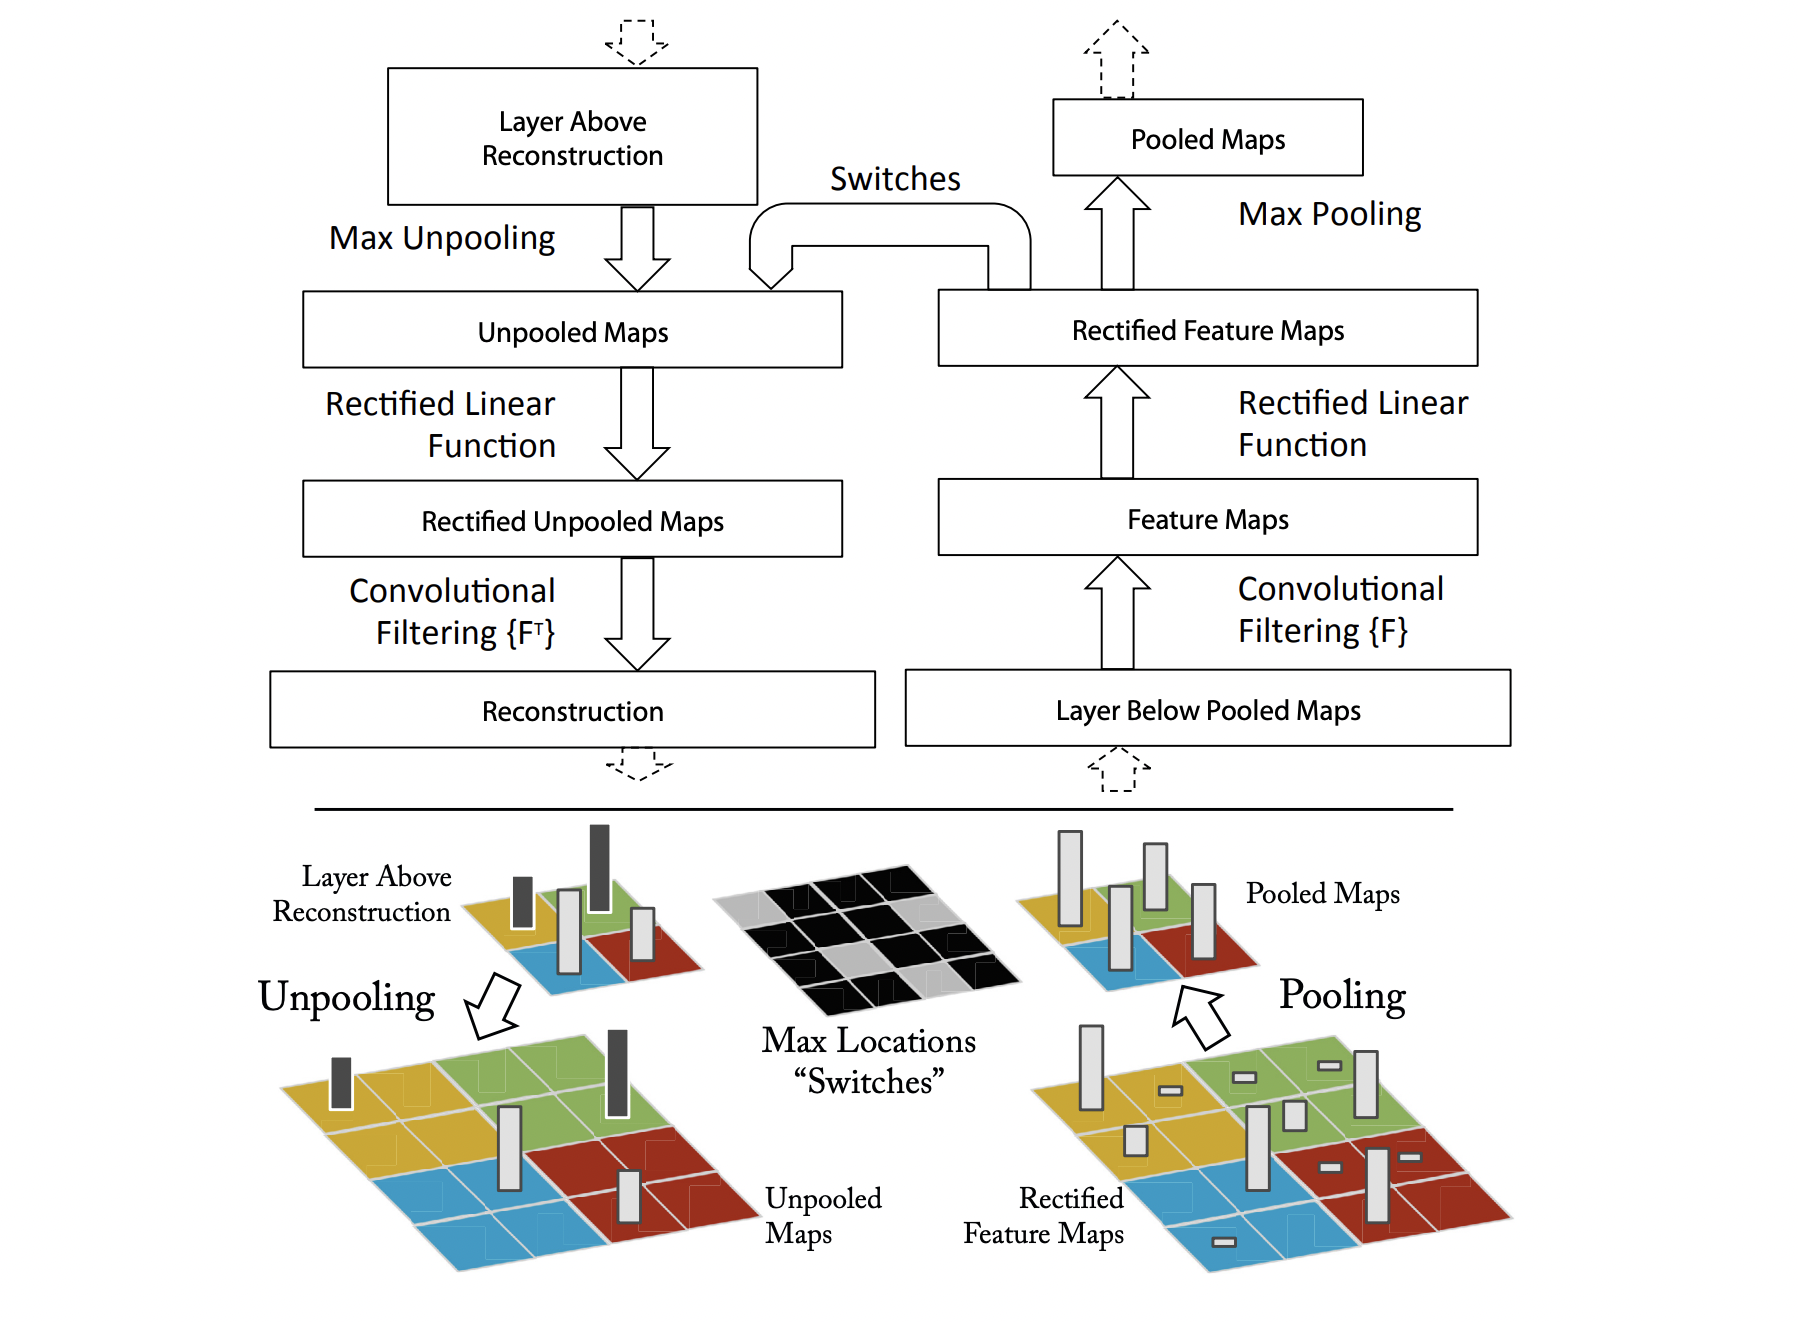

These visualisations are more visually interpretable than simply printing the raw filters.

In [68]:
def get_feature_maps(model, img, max_layers):
    """
    This function takes a PyTorch model, an input image and a maximum number of 
    layers to apply it to, and returns the raw feature map of the model along 
    with the deconvolution and unpooling layers applied to it.

    Args:
    model (torch.nn.Module): The PyTorch model to apply to the input image
    img (torch.Tensor): The input image to apply the model to
    max_layers (int): The maximum number of layers to apply

    Returns:
    tuple: A tuple containing:
    - img (torch.Tensor or numpy.array): The output feature map of the model applied to the input image
    - deconv_layers_list (List[torch.nn.Module]): A list of deconvolution layers applied to the feature map
    - unpool_layers_list (List[torch.Tensor]): A list of indices used for unpooling the feature map
    """
    deconv_layers_list = []
    unpool_layers_list = []

    # Go through each layer, get the feature maps, create either a deconv layer
    # or unpool layer depending on if its a Conv or MaxPool layer

    with torch.no_grad():
        x = img
        for i, layer in enumerate(model.features):
            x = layer(x)
            if isinstance(layer, torch.nn.Conv2d) and len(deconv_layers_list) < max_layers:
                deconv_layer = torch.nn.ConvTranspose2d(layer.out_channels, layer.in_channels, layer.kernel_size, stride=layer.stride, padding=layer.padding)
                deconv_layer.weight.data = layer.weight.data
                deconv_layer.bias.data = layer.bias.data
                deconv_layers_list.append(deconv_layer)
            elif isinstance(layer, torch.nn.MaxPool2d) and len(unpool_layers_list) < max_layers:
                unpool_layers_list.append(layer.return_indices)

            if len(deconv_layers_list) >= max_layers and len(unpool_layers_list) >= max_layers:
                break

        # Apply remaining layers
        for layer in model.classifier:
            x = layer(x)

    return x, deconv_layers_list, unpool_layers_list


def reconstruct_pixel_map(y, deconv_layers, unpool_layers):
    """
    This function takes an output feature map, a list of deconvolution layers 
    and a list of indices used for unpooling, and applies the deconvolution and 
    unpooling layers in reverse order to reconstruct the original input image with
    pixel space attributions.

    Args:
    y (torch.Tensor): The output feature map of a model applied to an input image
    deconv_layers (List[torch.nn.Module]): A list of deconvolution layers applied to the feature map
    unpool_layers (List[torch.Tensor]): A list of indices used for unpooling the feature map

    Returns:
    torch.Tensor: The reconstructed input image.
    """
    for i, layer in reversed(list(enumerate(deconv_layers))):
        y = layer(y)
        if i < len(unpool_layers):
            y = torch.nn.MaxUnpool2d(kernel_size=unpool_layers[i].kernel_size, stride=unpool_layers[i].stride, padding=unpool_layers[i].padding)(y, unpool_layers[i])
    return y


def visualize(layer_max_count, img):
    """
    This function takes a maximum number of layers to visualize and an 
    input image, converts the input image to a NumPy array, normalizes the pixel
    values and transposes the array to match the format required by 
    Matplotlib's imshow function. Finally, it displays the image 
    using Matplotlib.

    Args:
    layer_max_count (int): The maximum number of layers to visualize
    img (torch.Tensor): The input image to visualize

    Returns:
    None.
    (Should just visualize the image)
    """
    # Get the feature maps and deconv/unpool layers
    feature_maps, deconv_layers, unpool_layers = get_feature_maps(model, img, layer_max_count)

    # Reconstruct the pixel map using the deconv/unpool layers
    pixel_map = reconstruct_pixel_map(feature_maps, deconv_layers, unpool_layers)

    # Convert the tensor to a numpy array and normalize the pixel values
    pixel_map_np = pixel_map.detach().cpu().numpy()
    pixel_map_np = (pixel_map_np - pixel_map_np.min()) / (pixel_map_np.max() - pixel_map_np.min())

    # Transpose the array to match the format required by imshow
    pixel_map_np = np.transpose(pixel_map_np, (1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(pixel_map_np)
    plt.axis('off')
    plt.show()


In [70]:
# DO NOT CHANGE THIS CODE
raw_img = cv2.imread("/content/dog.jpg")
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

resized_img = cv2.resize(raw_img, (224, 224))

transform = transforms.Compose([
    transforms.ToTensor(),
])

input_img = transform(resized_img).unsqueeze_(0)

model = models.alexnet(pretrained=True).eval()
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    visualize(layer_max_count, input_img)

layer...2


TypeError: ignored

**I tried debugging the code but kept getting some error or another. Giving up here....**